### Instalando as bibliotecas necessárias

In [ ]:
!pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
!pip install mxnet==1.8.0.post0
!pip install -U insightface==0.2.1
!pip install onnx
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importando o modelo antelope do drive. Ele contém dois modelos pré-treinados, para deteção e reconhecimento, que estão no formato .onnx

In [13]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/antelope/antelope.zip -d /content/drive/MyDrive/antelope

In [ ]:
# importando as bibliotecas que serão utilizadas
import os
import pickle
import numpy as np
from PIL import Image
from typing import List
from tqdm import tqdm
import os
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from insightface.app import FaceAnalysis
from insightface.model_zoo import ArcFaceONNX
from sklearn.neighbors import NearestNeighbors

Utilizando um modelo pronto

In [ ]:
app = FaceAnalysis(name="/content/drive/MyDrive/antelope/antelope/")
app.prepare(ctx_id=0, det_size=(320, 320)) 

input mean and std: 127.5 127.5
find model: /content/drive/MyDrive/antelope/antelope/glintr100.onnx recognition
find model: /content/drive/MyDrive/antelope/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (320, 320)


Adicionando nosso dataset em um dicionário

In [ ]:
import os
import cv2
from tqdm import tqdm

rootdir = "/content/drive/MyDrive/data/post-processed/"
imgs = {}
total_files = sum([len(files) for _, _, files in os.walk(rootdir)])

with tqdm(total=total_files, desc="Reading Images", unit="image") as pbar:
    for subdir, dirs, files in os.walk(rootdir):
        key = subdir.split('/')[-1]
        img_list = []
        for file in files:
            filepath = os.path.join(subdir, file)
            img_color = cv2.imread(filepath)
            img_list.append(img_color)
            pbar.update(1)  # Atualiza a barra de progresso para cada imagem lida
        imgs[key] = img_list

primeira_chave, primeira_lista_imagens = list(imgs.items())[0]

Reading Images: 100%|██████████| 12000/12000 [48:25<00:00,  4.13image/s]


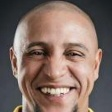

In [48]:
from google.colab.patches import cv2_imshow
cv2_imshow(imgs['Roberto_Carlos'][0])
cv2.waitKey(0)
cv2.destroyAllWindows()


### Gerando os embeddings

In [ ]:
emb_dicio = {}

for key, value in imgs.items():
    value_emb = []
    # Generating embeddings for an image
    for i in range(len(value)):
        img_emb_results = app.get(np.asarray(imgs[key][i]))
        if len(img_emb_results) > 0:
            value_emb.append(img_emb_results)
    emb_dicio.update({key: value_emb})

#### Train K NearestNeighbours

In [15]:
## lista de labels e lista de embs
labels = []
embs_list = []

for key, value in emb_dicio.items():
    for img in value:
        labels.append(key)
        embs_list.append(img)

In [16]:
# print(len(labels))
# print(len(embs_list))
print((embs_list[0][0].embedding))

[ 1.76261216e-01 -5.84186733e-01  4.57843363e-01  1.26891279e+00
  1.56993687e+00  5.70504427e-01 -1.33887485e-01 -9.96755064e-01
  3.86207730e-01  1.24547768e+00 -6.10154688e-01 -1.99122101e-01
 -1.87217265e-01 -4.66407001e-01  1.66090596e+00  5.86843729e-01
 -2.80800104e-01  5.71360588e-01 -9.57495570e-02  5.25888443e-01
 -1.81083941e+00 -7.13294923e-01 -5.82252860e-01 -3.30967188e+00
  1.93812120e+00  6.43064260e-01 -1.18943155e+00 -7.84892142e-01
 -6.41739368e-01 -8.65936279e-01 -1.00114524e-01  3.18348020e-01
 -1.33159488e-01  1.30338871e+00 -8.64434898e-01 -7.46768489e-02
  4.08238083e-01  6.82308674e-02  1.04348969e+00  1.68602720e-01
 -1.18206370e+00  4.40559447e-01 -6.12914085e-01 -5.33126771e-01
  1.02600664e-01 -1.07278287e+00 -1.35426807e+00  6.68563619e-02
 -7.58720875e-01 -9.14231539e-01 -1.46731436e+00  5.76435328e-01
  6.57072514e-02  1.03534055e+00  1.81226104e-01 -6.26600087e-01
 -2.13806581e+00 -7.07328022e-01 -8.80100489e-01 -4.96713333e-02
  7.10805535e-01 -1.23081

In [17]:
real_embs_list = []
for element in embs_list:
    real_embs_list.append(element[0].embedding)

In [18]:
# treinando o classificador KNN
nn = NearestNeighbors(n_neighbors=3, metric="cosine")
nn.fit(X=real_embs_list)

NearestNeighbors(metric='cosine', n_neighbors=3)

In [19]:
# salvando o modelo no drive
filename = '/content/drive/MyDrive/data/faceID_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(nn, file)

(1190, 1079, 3)
(820, 1079, 3)


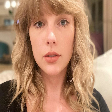

In [49]:
new_person = cv2.imread("/content/drive/MyDrive/data/Taylor_Swift/taylor_swift.jpg")
print(new_person.shape)
crop_img = new_person[180:1000, :]
print(crop_img.shape)
new_resized = cv2.resize(crop_img, (112, 112))

from google.colab.patches import cv2_imshow
cv2_imshow(new_resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [25]:
imgs.update({'Taylor Swift': [new_resized]})

In [28]:
## extraindo o embedding apenas dessa foto
emb_taylor = app.get(new_resized)[0].embedding
print(emb_taylor)

[ 4.81962085e-01 -3.35992873e-03  6.21559262e-01  8.29876214e-02
 -6.37163281e-01  1.49362195e+00 -5.88430166e-01  3.93353283e-01
 -7.88802981e-01 -1.35541940e+00  6.73665702e-01 -1.01872340e-01
 -1.54370165e+00  1.54120505e+00  1.07481050e+00 -1.00615370e+00
  2.95415491e-01  1.46742415e+00 -4.00748789e-01 -2.32197285e-01
  2.79683709e-01  4.74213243e-01  5.34631789e-01  1.00221431e+00
  5.93938470e-01  1.71364881e-02  3.05290192e-01  5.75920522e-01
  3.24069932e-02  1.42942286e+00 -3.54371697e-01 -4.00615245e-01
 -7.11757958e-01  1.00636351e+00  3.46525341e-01 -1.82182443e+00
  1.13544202e+00  5.09041369e-01 -2.16947556e-01  2.19433323e-01
  9.67733860e-02  7.89342523e-01  9.56604779e-01 -1.59360123e+00
  1.28323472e+00 -8.86041820e-02  8.72712553e-01 -6.00187033e-02
 -3.50059658e-01  7.55651176e-01  1.43664896e-01 -4.41209644e-01
  5.00885785e-01  7.04530001e-01  6.50740147e-01 -6.81218505e-01
 -7.13088736e-02  1.99763417e-01  2.96653628e-01  1.74209118e-01
  7.84566522e-01 -5.66512

In [29]:
## adicionando Taylor às labels
labels.append('Taylor Swift')
## adicionando o embedding da foto a real_embs_list
real_embs_list.append(emb_taylor)

### Inferência

In [30]:
# Treinando o classificador KNN 
nn = NearestNeighbors(n_neighbors=3, metric="cosine")
nn.fit(X=real_embs_list)

NearestNeighbors(metric='cosine', n_neighbors=3)

(1000, 737, 3)
(820, 737, 3)


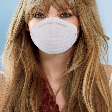

In [54]:
inf_taylor = cv2.imread("/content/drive/MyDrive/data/Taylor_Swift/taylor_inferencia.jpg")
print(inf_taylor.shape)
crop_img = inf_taylor[180:1000, :]
print(crop_img.shape)
crop_img_inf = cv2.resize(crop_img, (112, 112))

from google.colab.patches import cv2_imshow
cv2_imshow(crop_img_inf)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [55]:
emb_mask_taylor = app.get(crop_img_inf)[0].embedding
print(emb_mask_taylor)

[-1.64672628e-01 -5.48797846e-01  6.64630294e-01  3.72855723e-01
  1.27999112e-01  1.30883157e-01  7.80436099e-01  3.60134661e-01
 -5.69030344e-01 -5.81348777e-01 -6.88610598e-03 -1.34985685e-01
 -3.56207788e-01  1.68509930e-01 -5.34272790e-01  6.09119534e-02
 -8.95733356e-01  2.26707846e-01 -4.99853939e-01  7.03891754e-01
  2.24167109e-03  5.08288503e-01 -3.69506299e-01  4.02548730e-01
  7.08589256e-02  1.29316458e-02 -3.27469051e-01  8.08504045e-01
 -8.96220356e-02  1.66297483e+00  1.14192352e-01 -1.80292070e-01
 -3.26146275e-01 -4.24208827e-02  4.13110763e-01 -4.64841612e-02
  6.22782588e-01  9.23725426e-01 -7.56435812e-01  4.17303979e-01
 -1.20841384e+00  1.76337376e-01 -1.08015984e-02 -1.02092505e+00
  7.85963416e-01 -3.61926407e-01 -2.98280567e-01  5.23904525e-03
 -7.77625680e-01 -8.51906300e-01  1.27425089e-01 -3.18521410e-01
 -4.89361584e-04  3.87946784e-01  6.37987733e-01 -4.16638553e-01
  2.59835750e-01 -2.30265796e-01  8.57897222e-01  4.71288204e-01
 -4.44346160e-01  1.64693

In [56]:
unique_labels = list(dict.fromkeys(labels)) ## lista formada a partir das keys do nosso dicionário

In [57]:
real_imgs = []

for unique_label in unique_labels:
    temp = imgs[unique_label] # imagem correspondente àquela label no dicionário
    for img in temp:
        real_imgs.append(img)


In [59]:
dists, inds = nn.kneighbors(X=emb_mask_taylor.reshape(1,-1), n_neighbors=1, return_distance=True)

# extrai a label correspondente do vizinho mais próximo na lista labels
pred_labels = [labels[i] for i in inds[0]]

# printa a irnformação para o vizinho mais próximo
label, dist = pred_labels[0], dists[0][0]
print(f"Nearest neighbor found in the database is {label} and is at a distance of {dist}")



Nearest neighbor found in the database is Taylor Swift and is at a distance of 0.7980572581291199
